In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
import tensorflow_hub as hub
import gc, os, json
from sklearn.metrics import precision_recall_fscore_support

## Read in data and explore

This is text document classification dataset which contains 2225 text data and five categories of documents. Five categories are politics, sport, tech, entertainment and business. We can use this dataset for documents classification and document clustering.  

Dataset contains two features text and label.  
No. of Rows : 2225  
No. of Columns : 2  

Text:It contains different categories of text data  
**Label: ** It contains labels for five different categories : 0,1,2,3,4  

Politics = 0  
Sport = 1  
Technology = 2  
Entertainment = 3  
Business = 4  

In [4]:
df = pd.read_csv('df_file.csv')
df.head()

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2225 non-null   object
 1   Label   2225 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.9+ KB


In [ ]:
df.groupby('Label').size()

Label
0    417
1    511
2    401
3    386
4    510
dtype: int64

In [ ]:
for label in df['Label'].unique():
    text = df[df['Label'] == label]['Text'].values[0]
    print(f'Label: {label}, Text:{text} \n \n')

Label: 0, Text:Budget to set scene for election
 
 Gordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from Â£60,000. But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.
 
 Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about Â£2bn to spare.
 
 - Increase in the stamp duty threshold from Â£60,000 
  - A freeze on petrol duty 
  - An extension of tax credit scheme for poorer families 
  - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties' general election manifestos. Ten years ago, buyers had a muc

In [5]:
text_lengths = [len(text) for text in df['Text'].values]
text_lengths[0:10]

[3147, 3026, 3167, 3094, 2614, 2792, 2899, 2394, 3002, 2152]

In [6]:
mean_text_length = np.mean(text_lengths)
median_text_length = np.median(text_lengths)
percentile_95_length = np.percentile(text_lengths, 95)
print(f'Mean text length: {mean_text_length}')
print(f'Median text length: {median_text_length}')
print(f'95th percentile text length: {percentile_95_length}')

Mean text length: 2275.363595505618
Median text length: 1979.0
95th percentile text length: 4305.0


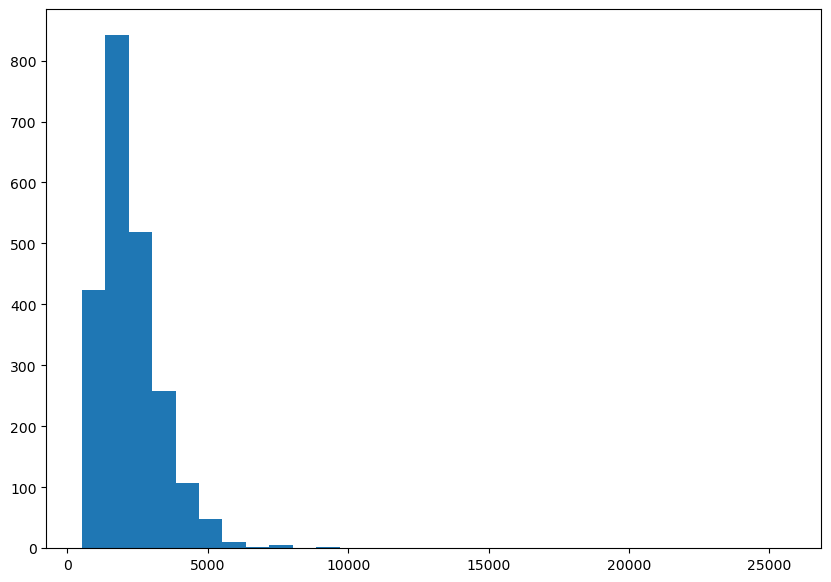

In [ ]:
plt.figure(figsize=(10, 7))
plt.hist(text_lengths, bins=30)
plt.show()

In [7]:
train_df = df.sample(frac=0.7, random_state=42)
val_df = df.drop(train_df.index).sample(frac=0.5, random_state=42)
test_df = df.drop(train_df.index).drop(val_df.index)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['Text'].values, train_df['Label'].values)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['Text'].values, val_df['Label'].values)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['Text'].values, test_df['Label'].values)).batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: Simple dense model with global pooling

In [ ]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=100_000, output_mode='int', output_sequence_length=int(percentile_95_length))
text_vectorizer.adapt(train_df['Text'].values)

embedding = tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()), output_dim=128, input_length=int(percentile_95_length))

In [ ]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, x, name='model_1_dense_pooling')

model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_1_history = model_1.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(model_1.name, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)
])

Epoch 1/50
48/49 [============================>.] - ETA: 0s - loss: 1.5953 - accuracy: 0.3047INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 43ms/step - loss: 1.5947 - accuracy: 0.3068 - val_loss: 1.5657 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 1.4900 - accuracy: 0.6098INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 36ms/step - loss: 1.4900 - accuracy: 0.6098 - val_loss: 1.3868 - val_accuracy: 0.7156 - lr: 0.0010
Epoch 3/50
48/49 [============================>.] - ETA: 0s - loss: 1.1055 - accuracy: 0.9108INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 38ms/step - loss: 1.1008 - accuracy: 0.9121 - val_loss: 0.8538 - val_accuracy: 0.8892 - lr: 0.0010
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.4842 - accuracy: 0.9814INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 38ms/step - loss: 0.4842 - accuracy: 0.9814 - val_loss: 0.3998 - val_accuracy: 0.9461 - lr: 0.0010
Epoch 5/50
48/49 [============================>.] - ETA: 0s - loss: 0.1710 - accuracy: 0.9915INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 36ms/step - loss: 0.1701 - accuracy: 0.9917 - val_loss: 0.2449 - val_accuracy: 0.9461 - lr: 0.0010
Epoch 6/50
49/49 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9968INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 38ms/step - loss: 0.0737 - accuracy: 0.9968 - val_loss: 0.1865 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 7/50
48/49 [============================>.] - ETA: 0s - loss: 0.0392 - accuracy: 0.9993INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 38ms/step - loss: 0.0391 - accuracy: 0.9994 - val_loss: 0.1593 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 8/50
49/49 [==============================] - ETA: 0s - loss: 0.0233 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 35ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.1449 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 9/50
48/49 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 39ms/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.1360 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 10/50
49/49 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 38ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.1305 - val_accuracy: 0.9641 - lr: 0.0010
Epoch 11/50
48/49 [============================>.] - ETA: 0s - loss: 0.0075 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 36ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.1266 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 12/50
49/49 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 38ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.1238 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 13/50
48/49 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 38ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.1217 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 14/50
49/49 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 36ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.1198 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 15/50
48/49 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 38ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.1185 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 16/50
49/49 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 35ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.1172 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 17/50
49/49 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 38ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1161 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 18/50
48/49 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 39ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1152 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 19/50
49/49 [==============================] - 1s 23ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1170 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 20/50
48/49 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 35ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1146 - val_accuracy: 0.9641 - lr: 0.0010
Epoch 21/50
48/49 [============================>.] - ETA: 0s - loss: 8.8552e-04 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 40ms/step - loss: 8.8459e-04 - accuracy: 1.0000 - val_loss: 0.1136 - val_accuracy: 0.9641 - lr: 0.0010
Epoch 22/50
47/49 [===========================>..] - ETA: 0s - loss: 7.2616e-04 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 38ms/step - loss: 7.2661e-04 - accuracy: 1.0000 - val_loss: 0.1130 - val_accuracy: 0.9641 - lr: 0.0010
Epoch 23/50
49/49 [==============================] - ETA: 0s - loss: 6.0585e-04 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


INFO:tensorflow:Assets written to: model_1_dense_pooling/assets


49/49 [==============================] - 2s 36ms/step - loss: 6.0585e-04 - accuracy: 1.0000 - val_loss: 0.1127 - val_accuracy: 0.9641 - lr: 0.0010
Epoch 24/50
49/49 [==============================] - 1s 24ms/step - loss: 5.1256e-04 - accuracy: 1.0000 - val_loss: 0.1128 - val_accuracy: 0.9641 - lr: 0.0010
Epoch 25/50
49/49 [==============================] - 1s 23ms/step - loss: 4.3852e-04 - accuracy: 1.0000 - val_loss: 0.1128 - val_accuracy: 0.9641 - lr: 0.0010
Epoch 26/50
49/49 [==============================] - 1s 24ms/step - loss: 3.7958e-04 - accuracy: 1.0000 - val_loss: 0.1129 - val_accuracy: 0.9641 - lr: 0.0010


In [ ]:
model_1.evaluate(test_dataset)

11/11 [==============================] - 0s 6ms/step - loss: 0.0868 - accuracy: 0.9790


[0.0868089571595192, 0.9789789915084839]

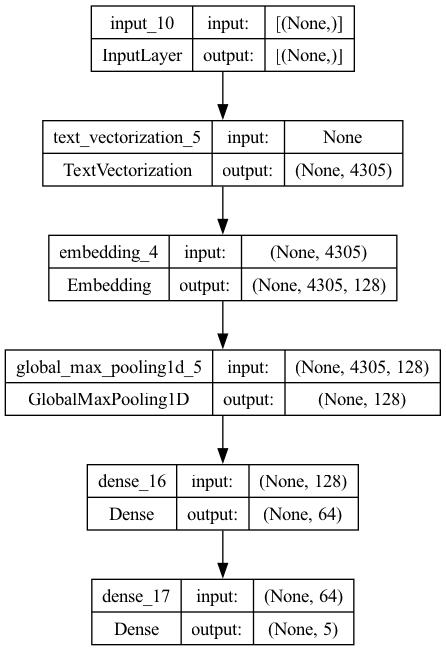

In [ ]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

## Model 2: LSTM model

In [18]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=100_000, output_mode='int', output_sequence_length=50, pad_to_max_tokens=True)
text_vectorizer.adapt(train_df['Text'].values)

embedding = tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()), output_dim=128, input_length=50)

In [19]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GRU(64)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs, name='model_2_lstm')

model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.legacy.Adam(), metrics=['accuracy'])
model_2_history = model_2.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(model_2.name, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)
])

Epoch 1/50
48/49 [============================>.] - ETA: 0s - loss: 1.5980 - accuracy: 0.2539INFO:tensorflow:Assets written to: model_2_lstm/assets


INFO:tensorflow:Assets written to: model_2_lstm/assets


49/49 [==============================] - 5s 89ms/step - loss: 1.5973 - accuracy: 0.2555 - val_loss: 1.5700 - val_accuracy: 0.3473 - lr: 0.0010
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 1.1755 - accuracy: 0.5924INFO:tensorflow:Assets written to: model_2_lstm/assets


INFO:tensorflow:Assets written to: model_2_lstm/assets


49/49 [==============================] - 4s 82ms/step - loss: 1.1755 - accuracy: 0.5924 - val_loss: 0.6926 - val_accuracy: 0.7335 - lr: 0.0010
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.9429INFO:tensorflow:Assets written to: model_2_lstm/assets


INFO:tensorflow:Assets written to: model_2_lstm/assets


49/49 [==============================] - 4s 83ms/step - loss: 0.2760 - accuracy: 0.9429 - val_loss: 0.4155 - val_accuracy: 0.8593 - lr: 0.0010
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9878INFO:tensorflow:Assets written to: model_2_lstm/assets


INFO:tensorflow:Assets written to: model_2_lstm/assets


49/49 [==============================] - 4s 79ms/step - loss: 0.0694 - accuracy: 0.9878 - val_loss: 0.3417 - val_accuracy: 0.8892 - lr: 0.0010
Epoch 5/50
49/49 [==============================] - 1s 25ms/step - loss: 0.0274 - accuracy: 0.9955 - val_loss: 0.4389 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 6/50
49/49 [==============================] - 1s 24ms/step - loss: 0.0231 - accuracy: 0.9942 - val_loss: 0.3927 - val_accuracy: 0.8862 - lr: 0.0010
Epoch 7/50
49/49 [==============================] - 1s 25ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.4416 - val_accuracy: 0.8772 - lr: 0.0010


In [9]:
model_2.evaluate(test_dataset)

11/11 [==============================] - 0s 6ms/step - loss: 0.3502 - accuracy: 0.9069


[0.350151002407074, 0.9069069027900696]

## Model 3: CNN / Conv1D

In [10]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=100_000, output_mode='int', output_sequence_length=int(percentile_95_length), pad_to_max_tokens=True)
text_vectorizer.adapt(train_df['Text'].values)

embedding = tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()), output_dim=128, input_length=int(percentile_95_length))

In [11]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs, name='model_3_conv1d')

model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_3_history = model_3.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(model_3.name, save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)
    ]
)

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 1.5651 - accuracy: 0.4082INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 8s 156ms/step - loss: 1.5651 - accuracy: 0.4082 - val_loss: 1.4699 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 1.0158 - accuracy: 0.8325INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 145ms/step - loss: 1.0158 - accuracy: 0.8325 - val_loss: 0.6395 - val_accuracy: 0.8772 - lr: 0.0010
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.9750INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 142ms/step - loss: 0.2004 - accuracy: 0.9750 - val_loss: 0.2759 - val_accuracy: 0.9222 - lr: 0.0010
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9981INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 145ms/step - loss: 0.0311 - accuracy: 0.9981 - val_loss: 0.2218 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 5/50
49/49 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 144ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.2015 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 6/50
49/49 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 151ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.1963 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 7/50
49/49 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 147ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.1926 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 8/50
49/49 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 146ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1902 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 9/50
49/49 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 147ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1886 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 10/50
49/49 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 147ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1874 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 11/50
49/49 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 150ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1866 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 12/50
49/49 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 150ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1860 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 13/50
49/49 [==============================] - ETA: 0s - loss: 8.4299e-04 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 146ms/step - loss: 8.4299e-04 - accuracy: 1.0000 - val_loss: 0.1855 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 14/50
49/49 [==============================] - ETA: 0s - loss: 7.1812e-04 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 147ms/step - loss: 7.1812e-04 - accuracy: 1.0000 - val_loss: 0.1852 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 15/50
49/49 [==============================] - ETA: 0s - loss: 6.1892e-04 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 149ms/step - loss: 6.1892e-04 - accuracy: 1.0000 - val_loss: 0.1850 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 16/50
49/49 [==============================] - ETA: 0s - loss: 5.3806e-04 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 146ms/step - loss: 5.3806e-04 - accuracy: 1.0000 - val_loss: 0.1849 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 17/50
49/49 [==============================] - ETA: 0s - loss: 4.7065e-04 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 149ms/step - loss: 4.7065e-04 - accuracy: 1.0000 - val_loss: 0.1848 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 18/50
49/49 [==============================] - ETA: 0s - loss: 4.1149e-04 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 146ms/step - loss: 4.1149e-04 - accuracy: 1.0000 - val_loss: 0.1848 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 19/50
49/49 [==============================] - ETA: 0s - loss: 3.6093e-04 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_3_conv1d/assets


INFO:tensorflow:Assets written to: model_3_conv1d/assets


49/49 [==============================] - 7s 148ms/step - loss: 3.6093e-04 - accuracy: 1.0000 - val_loss: 0.1847 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 20/50
49/49 [==============================] - 6s 131ms/step - loss: 3.1774e-04 - accuracy: 1.0000 - val_loss: 0.1847 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 21/50
49/49 [==============================] - 6s 131ms/step - loss: 2.8063e-04 - accuracy: 1.0000 - val_loss: 0.1848 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 22/50
49/49 [==============================] - 7s 136ms/step - loss: 2.4866e-04 - accuracy: 1.0000 - val_loss: 0.1850 - val_accuracy: 0.9371 - lr: 0.0010


In [12]:
model_3.evaluate(test_dataset)

11/11 [==============================] - 0s 30ms/step - loss: 0.1294 - accuracy: 0.9640


[0.12941887974739075, 0.9639639854431152]

## Model 4: CNN with dropout (due to overfitting)

In [48]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=100_000, output_mode='int', output_sequence_length=int(percentile_95_length), pad_to_max_tokens=True)
text_vectorizer.adapt(train_df['Text'].values)

embedding = tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()), output_dim=128, input_length=int(percentile_95_length))

In [49]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_4 = tf.keras.Model(inputs, outputs, name='model_4_conv1d')

model_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_4_history = model_4.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(model_4.name, save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)
    ]
)

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 1.6005 - accuracy: 0.2458INFO:tensorflow:Assets written to: model_4_conv1d/assets


INFO:tensorflow:Assets written to: model_4_conv1d/assets


49/49 [==============================] - 8s 161ms/step - loss: 1.6005 - accuracy: 0.2458 - val_loss: 1.5658 - val_accuracy: 0.4371 - lr: 0.0010
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 1.4880 - accuracy: 0.3935INFO:tensorflow:Assets written to: model_4_conv1d/assets


INFO:tensorflow:Assets written to: model_4_conv1d/assets


49/49 [==============================] - 7s 148ms/step - loss: 1.4880 - accuracy: 0.3935 - val_loss: 1.3382 - val_accuracy: 0.5988 - lr: 0.0010
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 1.0873 - accuracy: 0.6284INFO:tensorflow:Assets written to: model_4_conv1d/assets


INFO:tensorflow:Assets written to: model_4_conv1d/assets


49/49 [==============================] - 7s 150ms/step - loss: 1.0873 - accuracy: 0.6284 - val_loss: 0.7577 - val_accuracy: 0.8503 - lr: 0.0010
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.8017INFO:tensorflow:Assets written to: model_4_conv1d/assets


INFO:tensorflow:Assets written to: model_4_conv1d/assets


49/49 [==============================] - 7s 151ms/step - loss: 0.6333 - accuracy: 0.8017 - val_loss: 0.4278 - val_accuracy: 0.9012 - lr: 0.0010
Epoch 5/50
49/49 [==============================] - ETA: 0s - loss: 0.3360 - accuracy: 0.9114INFO:tensorflow:Assets written to: model_4_conv1d/assets


INFO:tensorflow:Assets written to: model_4_conv1d/assets


49/49 [==============================] - 7s 147ms/step - loss: 0.3360 - accuracy: 0.9114 - val_loss: 0.2910 - val_accuracy: 0.9311 - lr: 0.0010
Epoch 6/50
49/49 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9596INFO:tensorflow:Assets written to: model_4_conv1d/assets


INFO:tensorflow:Assets written to: model_4_conv1d/assets


49/49 [==============================] - 7s 150ms/step - loss: 0.1867 - accuracy: 0.9596 - val_loss: 0.2453 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 7/50
49/49 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.9596INFO:tensorflow:Assets written to: model_4_conv1d/assets


INFO:tensorflow:Assets written to: model_4_conv1d/assets


49/49 [==============================] - 7s 147ms/step - loss: 0.1401 - accuracy: 0.9596 - val_loss: 0.2300 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 8/50
49/49 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.9775INFO:tensorflow:Assets written to: model_4_conv1d/assets


INFO:tensorflow:Assets written to: model_4_conv1d/assets


49/49 [==============================] - 7s 150ms/step - loss: 0.0840 - accuracy: 0.9775 - val_loss: 0.1993 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 9/50
49/49 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9872INFO:tensorflow:Assets written to: model_4_conv1d/assets


INFO:tensorflow:Assets written to: model_4_conv1d/assets


49/49 [==============================] - 8s 154ms/step - loss: 0.0588 - accuracy: 0.9872 - val_loss: 0.1948 - val_accuracy: 0.9521 - lr: 0.0010
Epoch 10/50
49/49 [==============================] - 6s 131ms/step - loss: 0.0559 - accuracy: 0.9891 - val_loss: 0.1952 - val_accuracy: 0.9491 - lr: 0.0010
Epoch 11/50
49/49 [==============================] - 7s 134ms/step - loss: 0.0418 - accuracy: 0.9910 - val_loss: 0.2119 - val_accuracy: 0.9521 - lr: 0.0010
Epoch 12/50
49/49 [==============================] - 6s 131ms/step - loss: 0.0372 - accuracy: 0.9923 - val_loss: 0.1950 - val_accuracy: 0.9491 - lr: 0.0010


In [50]:
model_4.evaluate(test_dataset)

11/11 [==============================] - 0s 30ms/step - loss: 0.1213 - accuracy: 0.9640


[0.12133336812257767, 0.9639639854431152]

## Model 5: use tensorflow_hub pretrained embedding

In [58]:
embedding = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', input_shape=[], dtype=tf.string, trainable=False)

In [61]:
model_5 = tf.keras.Sequential([
    embedding,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
], name='model_5_hub_sentence_encoder')

model_5.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_5_history = model_5.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(model_5.name, save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)
    ]
)

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 1.3256 - accuracy: 0.7349INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 10s 179ms/step - loss: 1.3256 - accuracy: 0.7349 - val_loss: 0.9560 - val_accuracy: 0.9162 - lr: 0.0010
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 0.7007 - accuracy: 0.9249INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 145ms/step - loss: 0.7007 - accuracy: 0.9249 - val_loss: 0.4659 - val_accuracy: 0.9521 - lr: 0.0010
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.3784 - accuracy: 0.9454INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 147ms/step - loss: 0.3784 - accuracy: 0.9454 - val_loss: 0.2741 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.9570INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 154ms/step - loss: 0.2475 - accuracy: 0.9570 - val_loss: 0.1952 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 5/50
49/49 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.9673INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 147ms/step - loss: 0.1843 - accuracy: 0.9673 - val_loss: 0.1542 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 6/50
49/49 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.9679INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 146ms/step - loss: 0.1587 - accuracy: 0.9679 - val_loss: 0.1322 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 7/50
49/49 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9692INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 8s 158ms/step - loss: 0.1302 - accuracy: 0.9692 - val_loss: 0.1167 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 8/50
49/49 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9711INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 147ms/step - loss: 0.1136 - accuracy: 0.9711 - val_loss: 0.1065 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 9/50
49/49 [==============================] - ETA: 0s - loss: 0.1000 - accuracy: 0.9756INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 147ms/step - loss: 0.1000 - accuracy: 0.9756 - val_loss: 0.0987 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 10/50
49/49 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9705INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 152ms/step - loss: 0.0978 - accuracy: 0.9705 - val_loss: 0.0922 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 11/50
49/49 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.9782INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 148ms/step - loss: 0.0925 - accuracy: 0.9782 - val_loss: 0.0878 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 12/50
49/49 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9743INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 142ms/step - loss: 0.0864 - accuracy: 0.9743 - val_loss: 0.0877 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 13/50
49/49 [==============================] - ETA: 0s - loss: 0.0778 - accuracy: 0.9750INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 148ms/step - loss: 0.0778 - accuracy: 0.9750 - val_loss: 0.0843 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 14/50
49/49 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9833INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 155ms/step - loss: 0.0686 - accuracy: 0.9833 - val_loss: 0.0827 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 15/50
49/49 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.9827INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 152ms/step - loss: 0.0708 - accuracy: 0.9827 - val_loss: 0.0799 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 16/50
48/49 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9863INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 8s 161ms/step - loss: 0.0612 - accuracy: 0.9865 - val_loss: 0.0761 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 17/50
49/49 [==============================] - 1s 30ms/step - loss: 0.0571 - accuracy: 0.9833 - val_loss: 0.0790 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 18/50
49/49 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9865INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 149ms/step - loss: 0.0530 - accuracy: 0.9865 - val_loss: 0.0749 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 19/50
49/49 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9859INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 146ms/step - loss: 0.0522 - accuracy: 0.9859 - val_loss: 0.0719 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 20/50
49/49 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9923INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


INFO:tensorflow:Assets written to: model_5_hub_sentence_encoder/assets


49/49 [==============================] - 7s 149ms/step - loss: 0.0437 - accuracy: 0.9923 - val_loss: 0.0696 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 21/50
49/49 [==============================] - 1s 29ms/step - loss: 0.0443 - accuracy: 0.9884 - val_loss: 0.0722 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 22/50
49/49 [==============================] - 1s 29ms/step - loss: 0.0410 - accuracy: 0.9904 - val_loss: 0.0708 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 23/50
49/49 [==============================] - 2s 36ms/step - loss: 0.0390 - accuracy: 0.9917 - val_loss: 0.0705 - val_accuracy: 0.9820 - lr: 0.0010


## Model 6: Ensemble model

In [40]:
model_1 = tf.keras.models.load_model('model_1_dense_pooling')
model_2 = tf.keras.models.load_model('model_2_lstm')
model_4 = tf.keras.models.load_model('model_4_conv1d')
model_5 = tf.keras.models.load_model('model_5_hub_sentence_encoder')

In [41]:
ensemble_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

model_1_outputs = model_1(ensemble_inputs)
model_2_outputs = model_2(ensemble_inputs)
model_4_outputs = model_4(ensemble_inputs)
model_5_outputs = model_5(ensemble_inputs)

stacked_outputs = tf.stack([model_1_outputs, model_2_outputs, model_4_outputs, model_5_outputs], axis=0)
average_output = tf.reduce_mean(stacked_outputs, axis=0)

model_6 = tf.keras.Model(ensemble_inputs, average_output, name='model_6_ensemble')

model_6.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])


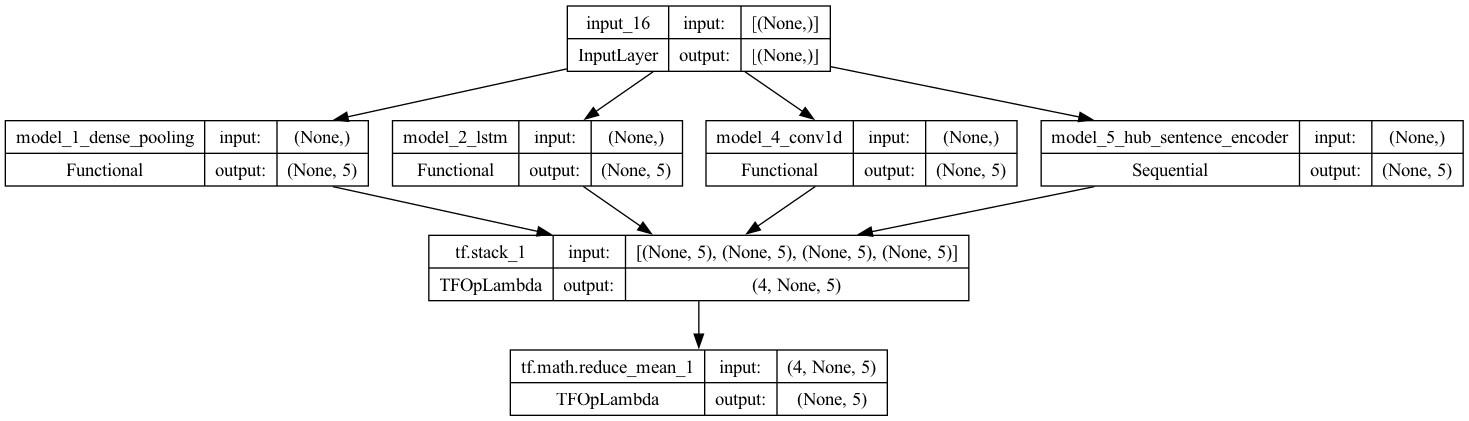

In [42]:
tf.keras.utils.plot_model(model_6, show_shapes=True)

In [43]:
model_6_history = model_6.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(model_6.name, save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)
    ]
)

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_6_ensemble/assets


INFO:tensorflow:Assets written to: model_6_ensemble/assets


49/49 [==============================] - 23s 391ms/step - loss: 0.0226 - accuracy: 1.0000 - val_loss: 0.1041 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 1.0000INFO:tensorflow:Assets written to: model_6_ensemble/assets


INFO:tensorflow:Assets written to: model_6_ensemble/assets


49/49 [==============================] - 18s 380ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.0956 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 3/50
49/49 [==============================] - 8s 165ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.1004 - val_accuracy: 0.9701 - lr: 0.0010
Epoch 4/50
49/49 [==============================] - 8s 158ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.0975 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 5/50
49/49 [==============================] - 8s 163ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.1000 - val_accuracy: 0.9731 - lr: 0.0010


In [44]:
model_6.evaluate(test_dataset)

11/11 [==============================] - 0s 41ms/step - loss: 0.0885 - accuracy: 0.9850


[0.0885075181722641, 0.9849849939346313]

## Compare model performance

In [9]:
model_1 = tf.keras.models.load_model('model_1_dense_pooling')
model_2 = tf.keras.models.load_model('model_2_lstm')
model_4 = tf.keras.models.load_model('model_4_conv1d')
model_5 = tf.keras.models.load_model('model_5_hub_sentence_encoder')
model_6 = tf.keras.models.load_model('model_6_ensemble')

model_1_preds = model_1.predict(test_dataset)
model_2_preds = model_2.predict(test_dataset)
model_4_preds = model_4.predict(test_dataset)
model_5_preds = model_5.predict(test_dataset)
model_6_preds = model_6.predict(test_dataset)

11/11 [==============================] - 1s 46ms/step


In [11]:
model_1_predictions = tf.squeeze(tf.argmax(model_1_preds, axis=1))
model_2_predictions = tf.squeeze(tf.argmax(model_2_preds, axis=1))
model_4_predictions = tf.squeeze(tf.argmax(model_4_preds, axis=1))
model_5_predictions = tf.squeeze(tf.argmax(model_5_preds, axis=1))
model_6_predictions = tf.squeeze(tf.argmax(model_6_preds, axis=1))

In [18]:
models = [model_1, model_2, model_4, model_5, model_6]
accuracies = []
precisions = []
recalls = []
f1_scores = []
for model in models:
    accuracies.append(model.evaluate(test_dataset)[1])
    precision_recall_f1_score_ = precision_recall_fscore_support(test_df['Label'], tf.squeeze(tf.argmax(model.predict(test_dataset), axis=1)), average='weighted')
    precisions.append(precision_recall_f1_score_[0])
    recalls.append(precision_recall_f1_score_[1])
    f1_scores.append(precision_recall_f1_score_[2])

11/11 [==============================] - 0s 40ms/step


In [29]:
model_results_df = pd.DataFrame(data={
    'Model': [model.name for model in models],
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
}).set_index('Model')

model_results_df

,Accuracy,Precision,Recall,F1 Score
Model,,,,
model_1_dense_pooling,0.978979,0.979967,0.978979,0.979011
model_2_lstm,0.888889,0.889226,0.888889,0.888590
model_4_conv1d,0.963964,0.964507,0.963964,0.963866
model_5_hub_sentence_encoder,0.972973,0.973740,0.972973,0.972916
model_6_ensemble,0.984985,0.985442,0.984985,0.984946


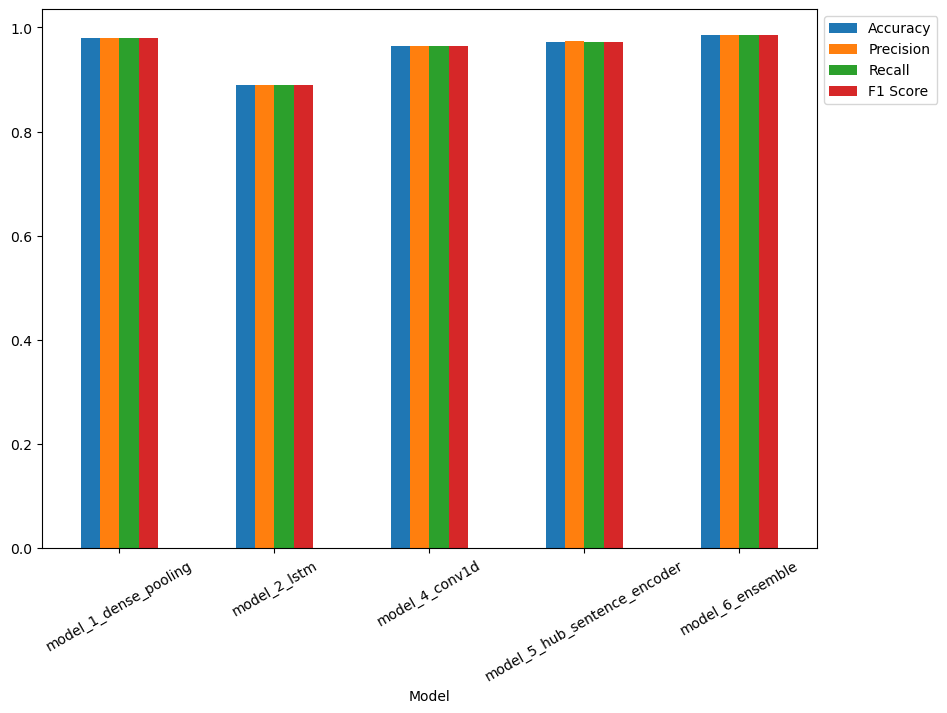

In [48]:
model_results_df.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=30)
plt.show()